In [358]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import typing as T
import importlib

import libq

In [486]:
pkw = { "marker" : ".", "markersize" : 3, "linewidth" : 1 }
ccli = "#1A936F"
csrv = "#F76C5E"

def _percentile_plot(ax, D, N=5, **kw):
    X = np.linspace(0, N, 100)
    P = 1 - 10. ** -X
    Y = np.percentile(D, P*100)
    XT = np.arange(0, N+1)
    XTL = 1 - 10. ** -XT
    ax.plot(X, Y, **kw)
    ax.set_xticks(XT)
    ax.set_xticklabels([ "{:.6g}".format(t) for t in XTL])

def plot_hists(stats):
    RT = stats.response_times()
    ST = stats.service_times()

    fig = plt.figure(figsize=(25,3))
    gs = fig.add_gridspec(1, 4)

    ax = fig.add_subplot(gs[0:1, 1:3])
    ax.set_title("Percentile Plot")
    _percentile_plot(ax, RT, color=ccli)
    _percentile_plot(ax, ST, color=csrv)

    ax = fig.add_subplot(gs[0:1, 0:1], sharey=None)
    ax.set_title("Latency Histogram")
    ax.hist(RT, bins=100, log=True, orientation="horizontal", color=ccli, alpha=0.5)
    ax.hist(ST, bins=100, log=True, orientation="horizontal", color=csrv, alpha=0.5)
    ax.invert_xaxis()
    ax.set_ylim(.1)
    


def plot_metrics(df):
    X = range(len(df))
    rows = 3
    fig = plt.figure(figsize=(25,15))

    ax = fig.add_subplot(rows, 1, 1)
    ax.set_title("Requests")
    ax.plot(X, df.r_request, color=ccli, label="request rate", **pkw)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    ax.plot(X, df.r_serviced, color=csrv, label="service rate", **pkw)
    ax.legend(loc="upper left")
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)

    ax = fig.add_subplot(rows, 1, 2, sharex=ax)
    ax.set_title("Saturation")
    ax.plot(X, df.pending, color=ccli, label="pending requests", **pkw)
    ax.plot(X, df.queued, color="grey", label="queue size", **pkw)
    ax.plot(X, df.active, color=csrv, label="active workers", **pkw)
    ax.legend(loc="upper left")
    ax.set_ylim(0.1, ax.get_ylim()[1]*1.2)

    ax = fig.add_subplot(rows, 1, 3, sharex=ax)
    ax.set_title("Latency Percentiles")
    ax.plot(X, df.response_time_p100, label="max request latency", color=ccli, alpha=0.5,**pkw)
    ax.plot(X, df.response_time_p50, label="p50 request latency", color=ccli, alpha=0.5,**pkw)
    ax.plot(X, df.service_time_p100, label="max service latency", color=csrv, alpha=0.5,**pkw)
    ax.plot(X, df.service_time_p50, label="p50 service latency", color=csrv, alpha=0.5,**pkw)
    ax.legend(loc="upper left")
    ax.set_ylim(0)

In [487]:
def noise(rate, N=10000):
    return np.random.poisson(rate,size=N)

def cat(*args):
    return np.concatenate(args)

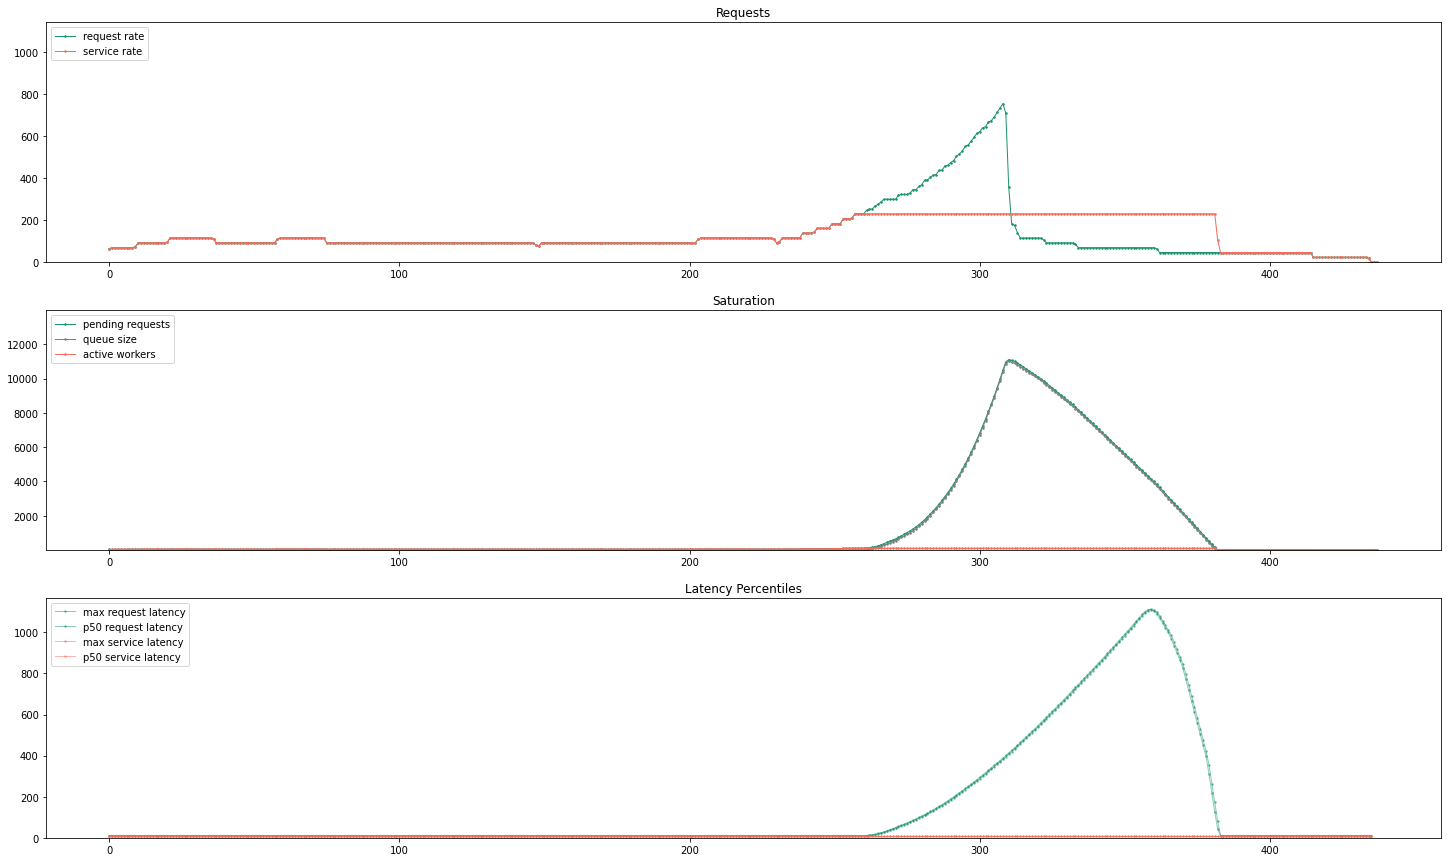

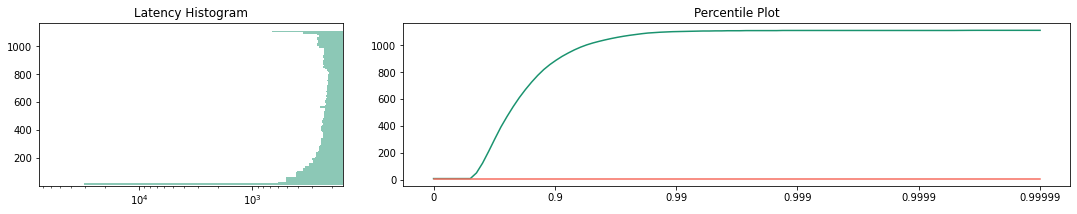

In [497]:
importlib.reload(libq)

# Capacity = 10rps
workers = [ libq.ConstWorker(service_time = 10) for _ in range(100) ]
sys = libq.QSystem(workers, discipline="fifo")

# wl = [10] * 100
# wl = noise(5) # half-loaded system
# wl = noise(9.5) # fully loaded system
# wl = noise(9.9) # at the edge
# wl = noise(10.1) # over the edge
# wl = cat( [0]*10, [1000]*10 ) # shock
# wl = np.linspace(0,20,1000) # rampup
# wl = np.load("./rate-pulses.npy") / 3.5
wl = np.load("./rate-hockey.npy") / 8.0

stats = libq.run(wl, sys, step=23, deplete=True)
df = stats.df(percentiles=[100, 90, 50])
plot_metrics(df)
plot_hists(stats)